# Monte Carlo Simulation with Dollar-Cost Averaging

Dollar Cost Averaging (DCA) is an investment strategy where one buys the same dollar amount of an asset over regular intervals in order to reduce short-term volatility.

# Import Libraries

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from scipy import stats
%matplotlib inline

import json
import requests
import datetime
import calendar
import random

# Obtain Bitcoin Price Data

In [42]:
H_URL = 'https://api.coindesk.com/v1/bpi/historical/close.json'
today = date.today().strftime("%Y-%m-%d")
# API powered by CoinDesk #


def fetch_hist_price(start_date = '2010-07-18', end_date = today):
    """Return historical price series of bitcoin in USD, 
    date entry in YYYY-MM-DD format, data starts 2010-07-18.
    """
        
    #Uses date parameters in API call
    payload = {'start': start_date, 'end': end_date}
    bpi_hist = requests.get(H_URL, params = payload).json()
    
    return bpi_hist["bpi"]

In [43]:
#Fetch bitcoin prices starting from 2010-07-18

spy_start = datetime.datetime(2010,7,18)
spy_end = datetime.date.today()

btc = fetch_hist_price()
df_spy = pd.DataFrame(list(btc.items()), columns=['Date', 'Close'])
df_spy

,Date,Close
0,2010-07-18,0.0858
1,2010-07-19,0.0808
2,2010-07-20,0.0747
3,2010-07-21,0.0792
4,2010-07-22,0.0505
...,...,...
3921,2021-04-12,59856.7133
3922,2021-04-13,63564.8333
3923,2021-04-14,62954.5883
3924,2021-04-15,63223.7683


In [24]:
# Create columns for year, month, and day
df_spy['Year'] = pd.DatetimeIndex(df_spy['Date']).year
df_spy['Month'] = pd.DatetimeIndex(df_spy['Date']).month
df_spy['Day'] = pd.DatetimeIndex(df_spy['Date']).day

df_spy

,Date,Close,Year,Month,Day
0,2010-07-18,0.0858,2010,7,18
1,2010-07-19,0.0808,2010,7,19
2,2010-07-20,0.0747,2010,7,20
3,2010-07-21,0.0792,2010,7,21
4,2010-07-22,0.0505,2010,7,22
...,...,...,...,...,...
3920,2021-04-11,59990.8733,2021,4,11
3921,2021-04-12,59856.7133,2021,4,12
3922,2021-04-13,63564.8333,2021,4,13
3923,2021-04-14,62954.5883,2021,4,14


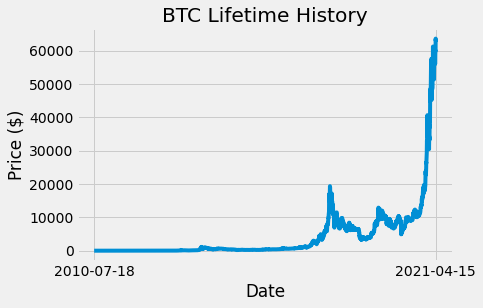

In [40]:
# Visualize Data
style.use('fivethirtyeight')

plt.plot(df_spy['Date'],df_spy['Close'])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('BTC Lifetime History')
plt.xticks([min(df_spy['Date']), max(df_spy['Date'])])
plt.show()

# Dollar Cost Averaging (DCA) Implementation

Invest $1000 per month in ETF. Once every month, randomly choose one day to purchase the maximum number of shares allowed with available buying power

In [10]:
def calc_dca(stock_data, dollars, num_months):
    # stock_data = historical data for stock
    # dollars = recurring monthly investment
    # num_months = number of months to calculate return for
    
    # Get date range (inception date to current)
    
    # First Date of Historical Date (First Trading Date - Not necessarily inception date)
    min_year = min(stock_data['Date']).year
    min_month = min(stock_data['Date']).month
    min_day = min(stock_data['Date']).day
    
    # Last Date of Historical Date (Current Date)
    max_year = max(stock_data['Date']).year
    max_month = max(stock_data['Date']).month
    max_day = max(stock_data['Date']).day

    # If inception month is December, use January aka month = 1
    # otherwise use the next month, aka month+1
    # this is to account for an incomplete month when getting random date
    if min_month == 12:
        l_lim_month = 1
        l_lim_year = min_year+1
    else:
        l_lim_month = min_month+1
        l_lim_year = min_year

    # If current month is January, subtract num_months+1 months from current 
    # ie. aka December from two years ago if num_months = 12
    # this is to account for an incomplete month
    quot = num_months//12 # number of full years
    rem = num_months%12 # remaining number of months
    
    if max_month == 1:
        u_lim_month_temp = 12
        u_lim_year_temp = max_year-1
    else:
        u_lim_month_temp = max_month-1
        u_lim_year_temp = max_year
    
    if rem > 0:        
        u_lim_month = 12-abs(u_lim_month_temp-rem)+1
        u_lim_year = u_lim_year_temp-quot
    else:
        u_lim_month = u_lim_month_temp
        u_lim_year = u_lim_year_temp-quot
    
    
    # List of valid months for randomized sampling
    num_months_start = 12-l_lim_month+1 # number of full months in the first year
    num_months_end = u_lim_month # number of full months in current year
    num_months_between = (u_lim_year-l_lim_year-1)*12

    num_months_total = num_months_start+num_months_end+num_months_between

    # start year
    s_y = []
    for a in range(num_months_start):
        year = l_lim_year
        month = a+l_lim_month
        s_y.append([year,month])

    # end year
    e_y = []
    for b in range(num_months_end):
        year = u_lim_year
        month = b+1
        e_y.append([year,month])

    # between years
    b_y = []
    for c in range(u_lim_year-l_lim_year-1):
        year = l_lim_year+c+1
        for j in range(12):
            month = j+1
            b_y.append([year,month])

    # all years
    a_y = s_y+b_y+e_y

    # Randomly select month to start investing
    rand_int = np.random.random_integers(0,num_months_total-1) # randomly select inclusive to bounds
    invest_start_year = a_y[rand_int][0]
    invest_start_month = a_y[rand_int][1]
    
    # Initalize variables
    year = [] # year of purchase
    month = [] # month of purchase
    day = [] # day of purchase
    deposit = np.zeros(num_months) # deposit
    invested = np.zeros(num_months) # total capital invested
    close_price = [] # closing price on date of purchase
    buy_pow_before = np.zeros(num_months) # buying power before purchase
    num_pur = np.zeros(num_months) # number of shares purchased
    num_owned_close = np.zeros(num_months) # number of shares owned after purchase
    num_owned_value = np.zeros(num_months) # value of total shares owned
    buy_pow_after = np.zeros(num_months) # buying power after purchase
    port_value = np.zeros(num_months) # portfolio value after purchase

    # Get randomized dates in each month
    # Get number of trading days

    # Create list of months for analysis
    months_analysis = []
    for i in range(num_months):
        if i == 0:
            analysis_year = invest_start_year
            analysis_month = invest_start_month
        elif months_analysis[i-1][1] == 12:
            analysis_year = months_analysis[i-1][0]+1
            analysis_month = 1
        else:
            analysis_year = months_analysis[i-1][0]
            analysis_month = months_analysis[i-1][1] + 1
        months_analysis.append([analysis_year,analysis_month])


    # Loop to randomly select one trading day in each month and get adjusted closing price and date
    for d in range(len(months_analysis)):
        temp = stock_data.loc[
            (stock_data['Year']==months_analysis[d][0]) & (stock_data['Month']==months_analysis[d][1])]
        rand_sample = pd.DataFrame.sample(temp)
        rand_sample_reset_ind = rand_sample.reset_index()
        months_analysis[d].append(rand_sample_reset_ind['Date'][0].day)
        months_analysis[d].append(rand_sample_reset_ind['Adj Close'][0])

    # 
    for e in range(num_months):
        year.append(months_analysis[e][0])
        month.append(months_analysis[e][1])
        day.append(months_analysis[e][2])
        deposit[e] += dollars
        close_price.append(months_analysis[e][3])
        if e == 0:
            invested[e] += dollars
            buy_pow_before[e] += dollars
            num_pur[e] += (buy_pow_before[e]//close_price[e])
            num_owned_close[e] += (num_pur[e])
            num_owned_value[e] += (close_price[e]*num_owned_close[e])
            buy_pow_after[e] += (buy_pow_before[e]-(num_pur[e]*close_price[e]))
            port_value[e] += (num_owned_value[e]+buy_pow_after[e])
        else:
            invested[e] += (invested[e-1]+deposit[e])
            buy_pow_before[e] += (deposit[e]+buy_pow_after[e-1])
            num_pur[e] += (buy_pow_before[e]//close_price[e])
            num_owned_close[e] += (num_owned_close[e-1]+num_pur[e])
            num_owned_value[e] += (close_price[e]*num_owned_close[e])
            buy_pow_after[e] += (buy_pow_before[e]-(num_pur[e]*close_price[e]))
            port_value[e] += (num_owned_value[e]+buy_pow_after[e])

    portfolio = pd.DataFrame(list(zip(year,month,day,deposit,close_price,invested,buy_pow_before,num_pur,
                                     num_owned_close,num_owned_value,buy_pow_after,port_value)),
                            columns = ['Year','Month','Day','Deposit','Close Price','Invested',
                                      'Buying Power Before','Number of Shares Purchased',
                                      'Number of Shares Owned at Close','Value of Number of Shares Owned',
                                      'Buying Power after','Portfolio Value'])

    ROI = (port_value[-1]-invested[-1])/invested[-1]
    
    return ROI

# SPY Simulation

In [11]:
# SPY 12-month simulation
num_iter = 20000
stock_data = df_spy
dollars = 1000
num_months = 12
spy12_sim_dat = []

for k in range(num_iter):
    x = calc_dca(stock_data, dollars, num_months)
    spy12_sim_dat.append(100*x)

C:\Users\mchin\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: This function is deprecated. Please call randint(0, 314 + 1) instead


(-40, 30)

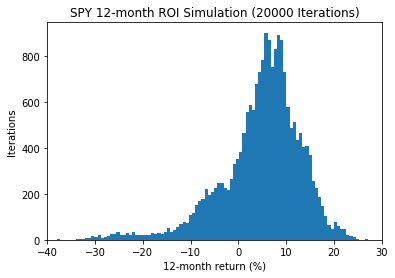

In [12]:
spy_hist = plt.hist(spy12_sim_dat,bins='auto')
plt.title('SPY ' + str(num_months) + '-month ROI Simulation (' + str(num_iter) + ' Iterations)')
plt.xlabel(str(num_months) + '-month return (%)')
plt.ylabel('Iterations')
plt.xlim([-40,30])

In [13]:
# Statistics
spy12_stat = pd.Series(spy12_sim_dat).describe()

In [14]:
# SPY 60-month simulation
num_iter = 20000
stock_data = df_spy
dollars = 1000
num_months = 60
spy60_sim_dat = []

for k in range(num_iter):
    x = calc_dca(stock_data, dollars, num_months)
    spy60_sim_dat.append(100*x)

C:\Users\mchin\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: This function is deprecated. Please call randint(0, 266 + 1) instead


(-50, 110)

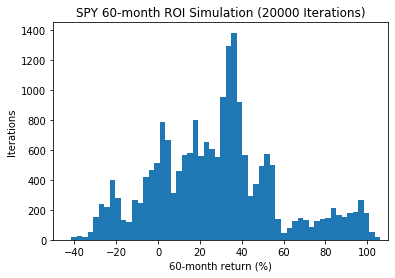

In [15]:
spy_hist = plt.hist(spy60_sim_dat,bins='auto')
plt.title('SPY ' + str(num_months) + '-month ROI Simulation (' + str(num_iter) + ' Iterations)')
plt.xlabel(str(num_months) + '-month return (%)')
plt.ylabel('Iterations')
plt.xlim([-50,110])

In [16]:
# Statistics
spy60_stat = pd.Series(spy60_sim_dat).describe()

# VOO Simulation

In [17]:
# VOO 12-month simulation
num_iter = 10000
stock_data = df_voo
dollars = 1000
num_months = 12
voo12_sim_dat = []

for k in range(num_iter):
    x = calc_dca(stock_data, dollars, num_months)
    voo12_sim_dat.append(100*x)

C:\Users\mchin\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: This function is deprecated. Please call randint(0, 102 + 1) instead


(-40, 30)

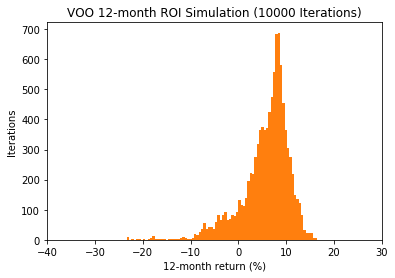

In [18]:
voo_hist = plt.hist(voo12_sim_dat,bins='auto',color='C1')
plt.title('VOO ' + str(num_months) + '-month ROI Simulation (' + str(num_iter) + ' Iterations)')
plt.xlabel(str(num_months) + '-month return (%)')
plt.ylabel('Iterations')
plt.xlim([-40,30])

In [19]:
# Statistics
voo12_stat = pd.Series(voo12_sim_dat).describe()

In [20]:
# VOO 60-month simulation
num_iter = 10000
stock_data = df_voo
dollars = 1000
num_months = 60
voo60_sim_dat = []

for k in range(num_iter):
    x = calc_dca(stock_data, dollars, num_months)
    voo60_sim_dat.append(100*x)

C:\Users\mchin\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: This function is deprecated. Please call randint(0, 54 + 1) instead


(-50, 110)

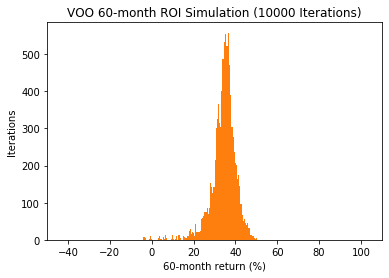

In [21]:
voo_hist = plt.hist(voo60_sim_dat,bins='auto',color='C1')
plt.title('VOO ' + str(num_months) + '-month ROI Simulation (' + str(num_iter) + ' Iterations)')
plt.xlabel(str(num_months) + '-month return (%)')
plt.ylabel('Iterations')
plt.xlim([-50,110])

In [22]:
# Statistics
voo60_stat = pd.Series(voo60_sim_dat).describe()

In [23]:
stat_12 = pd.concat([spy12_stat,voo12_stat],axis=1)
stat_12.columns = ['SPY','VOO']
stat_12.drop(['count'])

,SPY,VOO
mean,4.835290,5.794401
std,8.439565,4.974558
min,-37.990679,-23.370971
25%,1.096024,3.700996
50%,6.053805,6.976162
75%,10.039269,8.936903
max,27.168728,16.485067


In [24]:
stat_60 = pd.concat([spy60_stat,voo60_stat],axis=1)
stat_60.columns = ['SPY','VOO']
stat_60.drop(['count'])

,SPY,VOO
mean,27.883005,34.417106
std,29.553922,5.930463
min,-41.471978,-3.939725
25%,5.876389,31.823121
50%,29.337236,35.086169
75%,41.744492,37.682920
max,106.217828,50.515304
